<a href="https://colab.research.google.com/github/dnezan/km-sku-prediction/blob/main/KM_forecast_main_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KwickMetrics Forecast Practice**
Dinesh Sreekanthan<br>
https://github.com/dnezan/km-sku-prediction

# Data Overview
The dataset has 3 columns
<br>
*   SKU ID
*   Date
*   Number of items sold that day

By using the function `=COUNTUNIQUE(A:A)` in Google Spreadsheets or `Dataframe.unique()` in Pandas, we can find the number of unique items being sold. <br>

**There are 3 unique items being sold over a period of about 67 months (2016-05-08 - 2021-12-06)**

# Setting up Cloud Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive"

/content/drive/My Drive


In [3]:
!mkdir km-forecast-practice

mkdir: cannot create directory ‘km-forecast-practice’: File exists


In [4]:
%cd "/content/drive/My Drive/km-forecast-practice"

/content/drive/My Drive/km-forecast-practice


Make sure to move your dataset `km-forecast-practice.csv` to this folder.

In [5]:
!ls

'=4.0.0'
 amazon.com-2016-masked.csv
 amazon.com-2016-masked-datef.csv
 daily_data_processed.csv
 dataset-day-wise-amazon.com-masked2.csv
 dataset-day-wise-amazon.com-masked.gsheet
 dataset_new.csv
 dataset_new.gsheet
 fig.png
 frame_folder
 graph2.png
 graph3.png
 graph.svg
 graph_total.svg
 km-forecast-practice-data.csv
 my_awesome.gif
 OLDdataset-day-wise-amazon.com-masked.csv
 OLD_km-forecast-practice-data.csv
 requirements.txt
 results_1.gif
 results_2.gif
 results_3.gif
 results_4.gif
 results_5.gif
 results_6.gif
 temppp.csv
 traindate.csv
 traindate_z.csv


In [6]:
import pandas as pd
import csv
import datetime

dataset_name = 'dataset-day-wise-amazon.com-masked2.csv'
df=pd.read_csv(dataset_name)
df['timestamp']= pd.to_datetime(df['timestamp'])
print(df.dtypes)
df.head()

item_id               int64
timestamp    datetime64[ns]
demand                int64
dtype: object


,item_id,timestamp,demand
0,528,2016-05-08,0
1,528,2016-05-09,0
2,528,2016-05-10,0
3,528,2016-05-11,1
4,528,2016-05-12,2


# Preprocessing the Data
The first step is to rearrange the data so that we have each column representing a day and the rows containing the SKU ID. <br> 
We must also populate the data with missing dates, which we assume have 0 items sold on that day. So the first step is to add the missing dates, then set these as 0.

In [7]:
from dateutil.relativedelta import *

start_date=df.timestamp[0].date()  
end_date=df.timestamp.iat[-1].date()
start_sku=df.item_id[1]
print('Start date is',start_date)
print('End date is',end_date)
print("First SKU is",start_sku)

data = [[start_sku, 0]]

# Populating the new dataset with first row
df_new = pd.DataFrame(data, columns = ['SKU', start_date])
x = start_date

index = 2
var=0
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
num_days = (end_date-start_date).days

print("There are", num_months, "months between the two dates")
print("There are", num_days, "days between the two dates")

choice_num = input("Is your data daily or monthly? (d/m) ")
if (choice_num == 'd'):
  num_var = num_days
elif (choice_num == 'm'):
  num_var = num_months

while var<num_var:
  if (choice_num == 'd'):
    x+= datetime.timedelta(days=1)
  elif (choice_num == 'm'):
      x = x + relativedelta(months=+1)
  df_new.insert(loc=index, column=x, value=0)
  index+=1
  var+=1
year_mark = df_new
df_new.head()

Start date is 2016-05-08
End date is 2021-12-06
First SKU is 528
There are 67 months between the two dates
There are 2038 days between the two dates
Is your data daily or monthly? (d/m) d


,SKU,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,...,2021-10-28,2021-10-29,2021-10-30,2021-10-31,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04,2021-12-05,2021-12-06
0,528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we add all the unique products and populate the Dataframe with 0s. (Takes a few minutes to complete)

In [8]:
print(df_new.shape[1]) #number of columns

uniqval = list(df.item_id.unique()) #list of unique products
uniqval.pop(0)

x=0
while x < len(uniqval):
  listofzeros = [0] * (num_var + 1)
  listofzeros.insert(0, uniqval[x])
  df_length = len(df_new)
  df_new.loc[df_length] = listofzeros
  x+=1
  if(x%200==0):
    print(x)

print(df_new)

uniqval.insert(0,start_sku)

2040
    SKU  2016-05-08  2016-05-09  ...  2021-12-04  2021-12-05  2021-12-06
0   528           0           0  ...           0           0           0
1   529           0           0  ...           0           0           0
2  2336           0           0  ...           0           0           0

[3 rows x 2040 columns]


Next we fill in the values of items that were actually sold on a given day.

In [9]:
#Adding first product sales
count=-1

for y in uniqval:
  for x in df.item_id:
    if x == y: 
      count+=1
      z=df_new.columns.get_loc(pd.to_datetime(df.timestamp[count].date()).date())
      z1=df_new.index.get_loc(df_new.index[df_new['SKU'] == x][0])
      df_new.iloc[z1,z] = df.demand[count]
      
print("This product was sold on",count,"days")
df_new.head()

This product was sold on 5693 days


,SKU,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,...,2021-10-28,2021-10-29,2021-10-30,2021-10-31,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04,2021-12-05,2021-12-06
0,528,0,0,0,1,2,2,2,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,19,15,17,16,18,21,13,18,16,10,273,352,5,25,30,37,42,17,10,19,9,21,33,23,24,18,21,20,54,52,40,123,53,23,22,34,52,46,40
1,529,1,0,0,0,2,0,1,0,2,0,1,1,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,5,3,8,4,5,4,3,3,3,10,28,11,8,4,7,9,6,10,7,6,9,11,5,3,12,4,6,7,16,12,23,15,5,5,4,10,3,7
2,2336,0,0,1,0,0,0,1,1,0,1,2,0,1,0,0,1,2,1,0,0,1,0,0,0,1,1,0,0,0,0,20,40,0,1,2,0,0,2,0,...,24,19,16,20,23,23,21,23,19,17,28,24,37,23,29,35,33,41,37,38,39,42,39,33,41,53,49,33,37,86,84,67,84,57,18,18,49,62,59,39


In [10]:
df_new.to_csv('dataset_new.csv')

# Visualisation
Here we can visualise the sales of the first product in our dataset over a year.


In [11]:
import numpy as np 
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


#Enter random SKU here
a=0
b=1
c=2

product_name_x = str(df_new.SKU[a])
product_name_y = str(df_new.SKU[b])
product_name_z = str(df_new.SKU[c])

sales_x = df_new.iloc[a].tolist()
del sales_x[0] #remove item_id
sales_y = df_new.iloc[b].tolist()
del sales_y[0] #remove item_id
sales_z = df_new.iloc[c].tolist()
del sales_z[0] #remove item_id
dates_list = df_new.columns.tolist()
del dates_list[0] #remove column name

df_x = pd.DataFrame(np.transpose([dates_list, sales_x]))
df_x.columns = ["ds", "y"]
df_x["ds"]= pd.to_datetime(df_x["ds"])
print("")
print(product_name_x)
print(df_x.head(6))

df_y = pd.DataFrame(np.transpose([dates_list, sales_y]))
df_y.columns = ["ds", "y"]
df_y["ds"]= pd.to_datetime(df_y["ds"])
print("")
print(product_name_y)
print(df_y.head(6))

df_z = pd.DataFrame(np.transpose([dates_list, sales_z]))
df_z.columns = ["ds", "y"]
df_z["ds"]= pd.to_datetime(df_z["ds"])
print("")
print(product_name_z)
print(df_z.head(6))

###PLOTLY
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default='colab'

df_var = df_x

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

colors = ["#ff3a3c", "#99c0f7", "#73e0e7", '#de5200']
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_x,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()

##SKU 2
df_var = df_y

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

print("")

colors = px.colors.qualitative.Plotly
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_y,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()

##SKU3
df_var = df_z

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

print("")

colors = px.colors.qualitative.Plotly
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()





528
          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  0
3 2016-05-11  1
4 2016-05-12  2
5 2016-05-13  2

529
          ds  y
0 2016-05-08  1
1 2016-05-09  0
2 2016-05-10  0
3 2016-05-11  0
4 2016-05-12  2
5 2016-05-13  0

2336
          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  1
3 2016-05-11  0
4 2016-05-12  0
5 2016-05-13  0


# Wavelet Denoising 
Since the daily data is high frequency and very noisy, we can denoise the data to make it easier to understand from an analyst's perpspective.

*   DWT Denoising
*   Binning into weeks/months



# DWT denoising 
https://en.wikipedia.org/wiki/Wavelet

# **Modeling**

# Splitting Train-Validation-Test Models<br>
We can choose to train on the first 90 days of the dataset and then predict the next 30 days after that. This prediction can be validated with our validation set of 30 days after the training dataset.

In [29]:
train_range_start=0   
train_range_end=1020
test_range_start=1020
test_range_end=2039

df_train = df_z.iloc[train_range_start:train_range_end,:]
df_test = df_z.iloc[test_range_start:test_range_end,:]
df_test.reset_index(inplace = True, drop = True)
print(df_train.head(6))
print(df_test.head(6))

          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  1
3 2016-05-11  0
4 2016-05-12  0
5 2016-05-13  0
          ds   y
0 2019-02-22  10
1 2019-02-23   9
2 2019-02-24  15
3 2019-02-25   8
4 2019-02-26   9
5 2019-02-27  10


# Prophet

In [28]:
#import math
#from math import log, floor
#import pywt
#from statsmodels.robust import mad

#def maddest(d, axis=None):
#    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

#def denoise_signal(x, wavelet='db4', level=1):
#    coeff = pywt.wavedec(x, wavelet, mode="per")
#    sigma = (1/0.6745) * maddest(coeff[-level])

#    uthresh = sigma * np.sqrt(2*np.log(len(x)))
#    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

#    return pywt.waverec(coeff, wavelet, mode='per')

#og = df_train.copy()
#df_train['y'] = denoise_signal(df_train['y'])
#print(df_train)
#fig = go.Figure()
#fig.add_traces(go.Scatter(x=og['ds'], y = og['y'], mode = 'lines', line=dict(color="red"), name = 'Actual Sales'))

#fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Denoised Sales'))
#fig.update_layout(title = dict(text='Denoised Data for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
#fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
#fig.update_layout(legend_font_color="white")
#fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
#fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
#fig.show()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HOLIDAYS LIST:
0                 New Year's Day
1     Martin Luther King Jr. Day
2          Washington's Birthday
3                   Memorial Day
4               Independence Day
5                      Labor Day
6                   Columbus Day
7                   Veterans Day
8                   Thanksgiving
9                  Christmas Day
10      Christmas Day (Observed)
11     New Year's Day (Observed)
12       Veterans Day (Observed)
dtype: object

Train:
          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  1
3 2016-05-11  0
4 2016-05-12  0
5 2016-05-13  0

Test:
          ds
0 2019-02-22
1 2019-02-23
2 2019-02-24
3 2019-02-25
4 2019-02-26
5 2019-02-27

Forecast:
          ds       yhat  yhat_lower  yhat_upper
0 2019-02-22  16.652002    4.893920   28.923645
1 2019-02-23  16.381297    5.432554   27.938580
2 2019-02-24  17.334147    4.933375   29.877097
3 2019-02-25  19.588121    7.520985   31.341712
4 2019-02-26  20.601619    8.973098   32.697125
5 2019-02-27  19.263528  

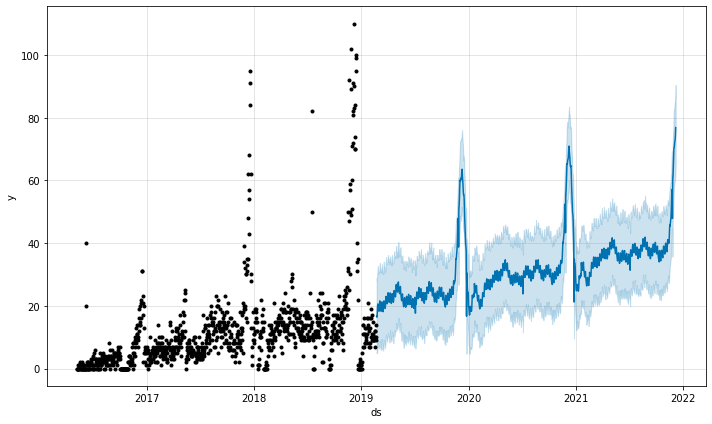

In [30]:
from fbprophet import Prophet
from pandas import to_datetime

#holidays = pd.DataFrame({
#  'holiday': 'playoff',
#  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                        '2010-01-24', '2010-02-07', '2011-01-08',
#                        '2013-01-12', '2014-01-12', '2014-01-19',
#                        '2014-02-02', '2015-01-11', '2016-01-17',
#                        '2016-01-24', '2016-02-07']),
#  'lower_window': 0,
#  'upper_window': 1,
#})

#model = Prophet(seasonality_mode='multiplicative') #hoiidays=holidays
model = Prophet() #hoiidays=holidays
model.add_country_holidays(country_name='US')
print("HOLIDAYS LIST:")



model.fit(df_train)
print(model.train_holiday_names)
print("")
print("Train:")
print(df_train.head(6))


future = df_test.iloc[:, 0]
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])


print("")
print("Test:")
print(future.head(6))
forecast = model.predict(future)

print("")
print("Forecast:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(6))


fig = model.plot(forecast)


In [31]:
df_var = df_z

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_upper'], mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_lower'], fill = 'tonexty', mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))


fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat'], mode = 'lines', line=dict(color=colors[1]), name = 'Predicted Sales'))
fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data (Denoised)'))

fig.update_layout(title_text='Daily Sales Prediction for Product SKU '+product_name_x, title_x=0.5)

fig.show()

In [32]:
forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
forecast_monthly.set_index('ds',inplace=True, drop=True)
forecast_monthly = forecast_monthly.resample('M').sum()
print(forecast_monthly)
df_overall_monthly = forecast_monthly.copy()
#fig = go.Figure()
#fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], fill = 'tonexty', mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))

#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines', line=dict(color="red"), name = 'Predicted Sales'))
#fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))

#fig.update_layout(title_text='Monthly Sales Prediction for Product SKU '+product_name_x, title_x=0.5)

#fig.show()

                   yhat   yhat_upper   yhat_lower
ds                                               
2019-02-28   128.887569   211.739169    45.595267
2019-03-31   623.016170   999.491103   245.853828
2019-04-30   687.033810  1053.973437   322.146684
2019-05-31   725.710832  1099.963817   348.181294
2019-06-30   634.818945  1001.172519   271.684713
2019-07-31   709.928173  1086.389297   329.667073
2019-08-31   753.439071  1131.528922   383.437076
2019-09-30   700.726060  1066.193059   332.034397
2019-10-31   699.997754  1077.787024   324.079834
2019-11-30   975.828972  1345.745257   614.797210
2019-12-31  1475.261031  1856.080186  1102.656015
2020-01-31   682.443110  1058.697599   306.023956
2020-02-29   653.999752  1009.356857   299.420007
2020-03-31   848.862796  1230.882253   466.104392
2020-04-30   898.094144  1263.757436   533.844294
2020-05-31   939.270787  1310.802428   561.247398
2020-06-30   851.534205  1220.104562   484.468525
2020-07-31   926.146804  1307.306271   541.593662


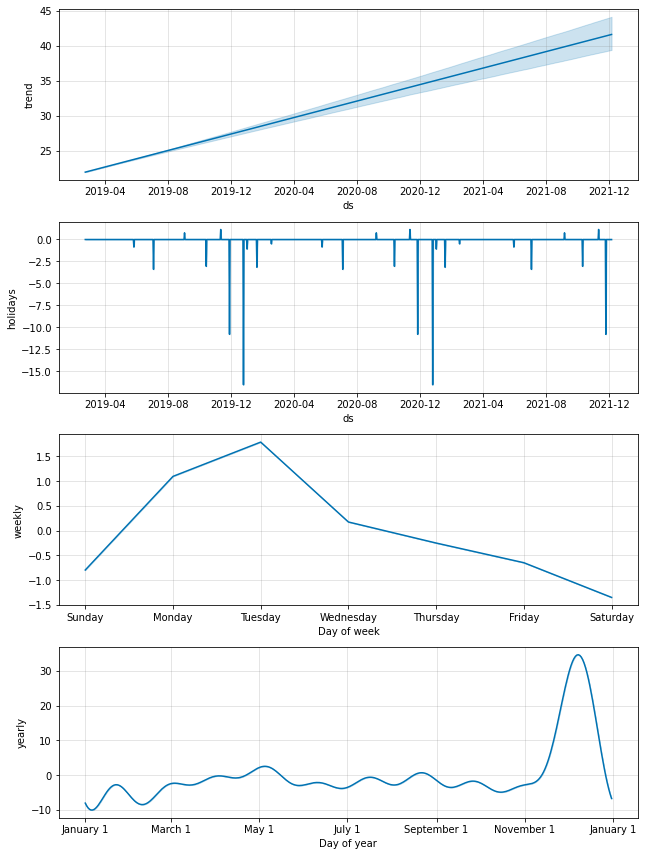

In [33]:
fig = model.plot_components(forecast)

# **Simulating Updating a Fitted Model**


In [18]:
!pip install pystan==2.19.1.1
!pip install prophet

In [19]:
!pip install kaleido


In [20]:
!pip install plotly==5.5.0

In [34]:
import pandas as pd

primeday_US = pd.DataFrame({
  'holiday': 'primeday_US',
  'ds': pd.to_datetime(['2016-07-12', '2017-07-11', '2018-07-16', '2019-07-15', '2019-07-16', '2020-07-21', '2020-07-22', '2021-07-21', '2021-07-22']),
  'lower_window': 0,
  'upper_window': 1,
})

blackfriday_US = pd.DataFrame({
  'holiday': 'blackfriday_US',
  'ds': pd.to_datetime(['2016-11-25', '2017-11-24', '2018-11-23', '2019-11-29', '2020-11-27', '2021-11-26']),
  'lower_window': 0,
  'upper_window': 1,
})

cybermonday_US = pd.DataFrame({
  'holiday': 'cybermonday_US',
  'ds': pd.to_datetime(['2016-11-28', '2017-11-27', '2018-11-26', '2019-12-02', '2020-11-30', '2021-11-29']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((primeday_US, blackfriday_US, cybermonday_US))

In [35]:
from fbprophet import Prophet
from pandas import to_datetime
from fbprophet import Prophet
import pandas as pd
import time
import numpy as np
import datetime
from datetime import datetime, timedelta
from datetime import datetime
import os
import glob
from PIL import Image
import plotly.express as px



df_z.to_csv("traindate_z.csv")
def stan_init(m):
  res = {}
  for pname in ['k', 'm', 'sigma_obs']:
    res[pname] = m.params[pname][0][0]
  for pname in ['delta', 'beta']:
    res[pname] = m.params[pname][0]
  return res

train_range_start=0   
train_range_end=1020
test_range_start=1020
 
first_date = test_range_start 
num_days = df_z.iloc[first_date]
print("numdays", num_days['ds'])
num_days_query = num_days['ds']
num_days = num_days_query.days_in_month
print(num_days)
days_left = (num_days_query.replace(day=1) + timedelta(days=32)).replace(day=1)
print("Days left till end of month")
days_left = days_left - num_days_query
days_left = days_left.days - 1
print(days_left)
first_date+=days_left
test_range_start = test_range_start
test_range_end=test_range_start + days_left + 1
print("Training from", df_z.iloc[train_range_start]['ds'], " to ", df_z.iloc[train_range_end]['ds'])
print("Testing from ", df_z.iloc[test_range_start + 1]['ds'], " to ", df_z.iloc[test_range_end - 1]['ds'])

df_train = df_z.iloc[train_range_start:train_range_end,:]
df_test = df_z.iloc[test_range_start:test_range_end,:]
df_test.reset_index(inplace = True, drop = True)


m1 = Prophet(changepoint_prior_scale=0.4, holidays=holidays) 


m1.add_country_holidays(country_name='US')
print(df_train)
print(df_test)
print("Fitting first time")
m1.fit(df_train)
future = df_test.iloc[:, 0]
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
forecast = m1.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(6))
forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
forecast_monthly.set_index('ds',inplace=True, drop=True)
forecast_monthly = forecast_monthly.resample('M').sum()

fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines+markers', line=dict(color="red"), name = 'Predicted Sales'))
fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))

fig.update_layout(title = dict(text='Monthly Sales Prediction for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_layout(autosize=False, width=1013, height=525)
fig.show()

first_date = test_range_start
ctr=0

print("Before loop")
print(train_range_start, train_range_end, test_range_start, test_range_end)

forecast_monthly_history = pd.DataFrame(columns = ['yhat', 'yhat_upper', 'yhat_lower'])
forecast_monthly_history.index = pd.to_datetime(forecast_monthly_history.index)
print("Starting to track prediction history...")

while test_range_end + 30 <= 2039:
  train_range_end = test_range_end - 1
  test_range_start = train_range_end + 1
  num_days = df_z.iloc[test_range_start]
  num_days_query = num_days['ds']
  num_days = num_days_query.days_in_month
  print(num_days)
  test_range_end = test_range_start + num_days
  
  print("Training from", df_z.iloc[train_range_start]['ds'], " to ", df_z.iloc[train_range_end]['ds'])
  print("Testing from ", df_z.iloc[test_range_start]['ds'], " to ", df_z.iloc[test_range_end-1]['ds'])

  df_train = df_z.iloc[train_range_start:train_range_end,:]
  df_test = df_z.iloc[test_range_start:test_range_end,:]
  df_test.reset_index(inplace = True, drop = True)

  #print(df_train.tail(10))

  
  m2 = Prophet(changepoint_prior_scale=0.4, holidays=holidays)


  m2.add_country_holidays(country_name='US')
  print("Fitting second time")
  if ('02-29') not in str(df_z.iloc[test_range_end-1]['ds']):
    m2.fit(df_train, init=stan_init(m1))
    future = df_test.iloc[:, 0]
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= to_datetime(future['ds'])
    forecast = m2.predict(future)
    m1=m2
  else:
    
    
    m1 = Prophet(changepoint_prior_scale=0.4, holidays=holidays) #hoiidays=holidays


    m1.add_country_holidays(country_name='US')
    m1.fit(df_train)
    future = df_test.iloc[:, 0]
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= to_datetime(future['ds'])
    forecast = m1.predict(future)

  forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
  forecast_monthly.set_index('ds',inplace=True, drop=True)
  forecast_monthly = forecast_monthly.resample('M').sum()

  if(forecast_monthly.iloc[0]['yhat'] < 0):
    forecast_monthly.iloc[0]['yhat'] = 0
  if(forecast_monthly.iloc[0]['yhat_upper']<0):
    forecast_monthly.iloc[0]['yhat_upper'] = 0
  if(forecast_monthly.iloc[0]['yhat_lower']<0):
    forecast_monthly.iloc[0]['yhat_lower'] = 0
    forecast_monthly.iloc[0]['yhat'] = (forecast_monthly.iloc[0]['yhat_lower'] + forecast_monthly.iloc[0]['yhat_upper'] ) / 2
  print(forecast_monthly)

  actual_text_date=0
  actual_text_flag = 0
  x=0
  #while actual_text_flag == 0:
  #  print(forecast_monthly.iloc[0].index.values)
  #  print(monthly_df.iloc[x].index.values)
    #if forecast_monthly.iloc[0].index == monthly_df.iloc[x].index:
    #  actual_text_date=monthly_df.iloc[x]['y'] 
    #  actual_text_flag+=1  
  #  x+=1
   #for printing actual sales
  
  fig = go.Figure()
  fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
  
  fig.add_traces(go.Scatter(x=pd.to_datetime(df_overall_monthly.index.values), y = df_overall_monthly['yhat'], mode = 'lines', line=dict(color="sandybrown"), name = 'Predicted Sales (not updating monthly)'))

  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="red"), name = 'Predicted Sales Upper Limit (updated monthly)'))
  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales Lower Limit (updated monthly)'))


  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines+markers', line=dict(color="red"), name = 'Predicted Sales (updated monthly)'))
  
  fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))


  forecast_monthly_history = forecast_monthly_history.append(forecast_monthly)
  print(forecast_monthly_history)

  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly_history.index.values), y = forecast_monthly_history['yhat'], mode = 'lines', line=dict(color="indianred"), name = 'History'))

  fig.update_layout(title = dict(text='Monthly Sales Prediction for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
  fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
  fig.update_layout(legend_font_color="white")
  fig.update_layout(width=1013, height=525)
  fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
  fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')  
  fig.update_xaxes(rangemode="tozero")
  fig.update_yaxes(rangemode="tozero")
  

  predicted_month = forecast_monthly.index.values
  predicted_month = pd.to_datetime(predicted_month)
  predicted_month = predicted_month.strftime('%b')
  
  predicted_month = str(predicted_month)
  predicted_month = predicted_month.replace("Index(['",'')
  predicted_month = predicted_month.replace("'], dtype='object')",'')
  #predicted_month = predicted_month.astype('str')
  print(predicted_month)

  text_sales = forecast_monthly.iloc[0]['yhat']
  text_sales = "Your monthly sales prediction for " + predicted_month + " is " + str(int(text_sales)) + " (" + str(int(forecast_monthly.iloc[0]['yhat_lower'])) + " - " + str(int(forecast_monthly.iloc[0]['yhat_upper'])) + ")"
  fig.add_annotation(dict(font=dict(color='white',size=15),
                                        x=0,
                                        y=-0.15,
                                        showarrow=False,
                                        text=text_sales,
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
  
  text_sales2 = 100
  text_sales = "Actual sales is " + str(int(text_sales2))
  fig.add_annotation(dict(font=dict(color='white',size=15),
                                        x=0,
                                        y=-0.2,
                                        showarrow=False,
                                        text=text_sales,
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))


  fig.show()
  ctr=ctr+1
  s1 = "frame_folder/fig0"
  s2 = str(ctr)
  s3 = ".png"
  s4=s1+s2+s3
  print(s4)
  fig.write_image(s4)
  if (test_range_end + 30 >= 2039):
    print("INSUFFICIENT DATA TO MAKE A MONTHLY PREDICTION")







INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


numdays 2019-02-22 00:00:00
28
Days left till end of month
6
Training from 2016-05-08 00:00:00  to  2019-02-22 00:00:00
Testing from  2019-02-23 00:00:00  to  2019-02-28 00:00:00
             ds   y
0    2016-05-08   0
1    2016-05-09   0
2    2016-05-10   1
3    2016-05-11   0
4    2016-05-12   0
...         ...  ..
1015 2019-02-17   7
1016 2019-02-18  12
1017 2019-02-19   9
1018 2019-02-20  14
1019 2019-02-21  10

[1020 rows x 2 columns]
          ds   y
0 2019-02-22  10
1 2019-02-23   9
2 2019-02-24  15
3 2019-02-25   8
4 2019-02-26   9
5 2019-02-27  10
6 2019-02-28  10
Fitting first time
          ds       yhat  yhat_lower  yhat_upper
0 2019-02-22  10.532712   -0.857071   21.129778
1 2019-02-23  10.061931   -0.972738   20.523529
2 2019-02-24  10.843202   -0.031950   22.319087
3 2019-02-25  12.400448    0.439555   23.658608
4 2019-02-26  13.180441    1.345259   24.645495
5 2019-02-27  11.883007    0.590158   23.251455


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Before loop
0 1020 1020 1027
Starting to track prediction history...
31
Training from 2016-05-08 00:00:00  to  2019-02-28 00:00:00
Testing from  2019-03-01 00:00:00  to  2019-03-31 00:00:00
Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-03-31  312.520633  625.041266         0.0
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266         0.0
Mar


frame_folder/fig01.png
30
Training from 2016-05-08 00:00:00  to  2019-03-31 00:00:00
Testing from  2019-04-01 00:00:00  to  2019-04-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                 yhat  yhat_upper  yhat_lower
ds                                           
2019-04-30  303.33683  606.673661         0.0
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266         0.0
2019-04-30  303.336830  606.673661         0.0
Apr


frame_folder/fig02.png
31
Training from 2016-05-08 00:00:00  to  2019-04-30 00:00:00
Testing from  2019-05-01 00:00:00  to  2019-05-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-05-31  306.748687  613.497374         0.0
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266         0.0
2019-04-30  303.336830  606.673661         0.0
2019-05-31  306.748687  613.497374         0.0
May


frame_folder/fig03.png
30
Training from 2016-05-08 00:00:00  to  2019-05-31 00:00:00
Testing from  2019-06-01 00:00:00  to  2019-06-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-06-30  307.998148  615.996297         0.0
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266         0.0
2019-04-30  303.336830  606.673661         0.0
2019-05-31  306.748687  613.497374         0.0
2019-06-30  307.998148  615.996297         0.0
Jun


frame_folder/fig04.png
31
Training from 2016-05-08 00:00:00  to  2019-06-30 00:00:00
Testing from  2019-07-01 00:00:00  to  2019-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                 yhat  yhat_upper  yhat_lower
ds                                           
2019-07-31  289.19488  578.389759         0.0
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266         0.0
2019-04-30  303.336830  606.673661         0.0
2019-05-31  306.748687  613.497374         0.0
2019-06-30  307.998148  615.996297         0.0
2019-07-31  289.194880  578.389759         0.0
Jul


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


frame_folder/fig05.png
31
Training from 2016-05-08 00:00:00  to  2019-07-31 00:00:00
Testing from  2019-08-01 00:00:00  to  2019-08-31 00:00:00
Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-08-31  254.336685  508.673371         0.0
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266         0.0
2019-04-30  303.336830  606.673661         0.0
2019-05-31  306.748687  613.497374         0.0
2019-06-30  307.998148  615.996297         0.0
2019-07-31  289.194880  578.389759         0.0
2019-08-31  254.336685  508.673371         0.0
Aug


frame_folder/fig06.png
30
Training from 2016-05-08 00:00:00  to  2019-08-31 00:00:00
Testing from  2019-09-01 00:00:00  to  2019-09-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-09-30  249.681756  499.363512         0.0
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266         0.0
2019-04-30  303.336830  606.673661         0.0
2019-05-31  306.748687  613.497374         0.0
2019-06-30  307.998148  615.996297         0.0
2019-07-31  289.194880  578.389759         0.0
2019-08-31  254.336685  508.673371         0.0
2019-09-30  249.681756  499.363512         0.0
Sep


frame_folder/fig07.png
31
Training from 2016-05-08 00:00:00  to  2019-09-30 00:00:00
Testing from  2019-10-01 00:00:00  to  2019-10-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-10-31  268.234792  536.469583         0.0
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266         0.0
2019-04-30  303.336830  606.673661         0.0
2019-05-31  306.748687  613.497374         0.0
2019-06-30  307.998148  615.996297         0.0
2019-07-31  289.194880  578.389759         0.0
2019-08-31  254.336685  508.673371         0.0
2019-09-30  249.681756  499.363512         0.0
2019-10-31  268.234792  536.469583         0.0
Oct


frame_folder/fig08.png
30
Training from 2016-05-08 00:00:00  to  2019-10-31 00:00:00
Testing from  2019-11-01 00:00:00  to  2019-11-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-11-30  450.449797  743.100922  154.768911
                  yhat  yhat_upper  yhat_lower
2019-03-31  312.520633  625.041266    0.000000
2019-04-30  303.336830  606.673661    0.000000
2019-05-31  306.748687  613.497374    0.000000
2019-06-30  307.998148  615.996297    0.000000
2019-07-31  289.194880  578.389759    0.000000
2019-08-31  254.336685  508.673371    0.000000
2019-09-30  249.681756  499.363512    0.000000
2019-10-31  268.234792  536.469583    0.000000
2019-11-30  450.449797  743.100922  154.768911
Nov


frame_folder/fig09.png
31
Training from 2016-05-08 00:00:00  to  2019-11-30 00:00:00
Testing from  2019-12-01 00:00:00  to  2019-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2019-12-31  1987.109755  2322.756106  1653.693557
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
Dec


frame_folder/fig010.png
31
Training from 2016-05-08 00:00:00  to  2019-12-31 00:00:00
Testing from  2020-01-01 00:00:00  to  2020-01-31 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                 yhat   yhat_upper   yhat_lower
ds                                             
2020-01-31  1481.6502  1859.434198  1104.385447
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
Jan


frame_folder/fig011.png
29
Training from 2016-05-08 00:00:00  to  2020-01-31 00:00:00
Testing from  2020-02-01 00:00:00  to  2020-02-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2020-02-29  435.301842  797.656358   76.317752
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
Feb


frame_folder/fig012.png
31
Training from 2016-05-08 00:00:00  to  2020-02-29 00:00:00
Testing from  2020-03-01 00:00:00  to  2020-03-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2020-03-31  490.754972  887.575623   97.981723
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
Mar


frame_folder/fig013.png
30
Training from 2016-05-08 00:00:00  to  2020-03-31 00:00:00
Testing from 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 2020-04-01 00:00:00  to  2020-04-30 00:00:00
Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2020-04-30  379.789253  759.578506         0.0
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
Apr


frame_folder/fig014.png
31
Training from 2016-05-08 00:00:00  to  2020-04-30 00:00:00
Testing from  2020-05-01 00:00:00  to  2020-05-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2020-05-31  1074.143455  1486.776308  657.950561
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
May


frame_folder/fig015.png
30
Training from 2016-05-08 00:00:00  to  2020-05-31 00:00:00
Testing from  2020-06-01 00:00:00  to  2020-06-30 00:00:00
Fitting second time

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



                   yhat   yhat_upper   yhat_lower
ds                                               
2020-06-30  1483.768622  1887.671238  1075.608608
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671238  1075.608608

frame_folder/fig016.png
31
Training from 2016-05-08 00:00:00  to  2020-06-30 00:00:00
Testing from  2020-07-01 00:00:00  to  2020-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-07-31  1860.274289  2276.809137  1447.003273
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.

frame_folder/fig017.png
31
Training from 2016-05-08 00:00:00  to  2020-07-31 00:00:00
Testing from  2020-08-01 00:00:00  to  2020-08-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-08-31  1570.168444  1995.997166  1143.662265
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.

frame_folder/fig018.png
30

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Training from 2016-05-08 00:00:00  to  2020-08-31 00:00:00
Testing from  2020-09-01 00:00:00  to  2020-09-30 00:00:00
Fitting second time
                 yhat   yhat_upper   yhat_lower
ds                                             
2020-09-30  1450.7349  1862.239294  1042.309519
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.

frame_folder/fig019.png
31
Training from 2016-05-08 00:00:00  to  2020-09-30 00:00:00
Testing from  2020-10-01 00:00:00  to  2020-10-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat  yhat_upper  yhat_lower
ds                                             
2020-10-31  1325.012495  1727.79934  923.571905
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671238

frame_folder/fig020.png
30
Training from 2016-05-08 00:00:00  to  2020-10-31 00:00:00
Testing from  2020-11-01 00:00:00  to  2020-11-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-11-30  1630.690911  2020.075011  1239.526822
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.

frame_folder/fig021.png
31
Training from 2016-05-08 00:00:00  to  2020-11-30 00:00:00
Testing from  2020-12-01 00:00:00  to  2020-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-12-31  2714.682579  3152.483121  2281.217545
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.

frame_folder/fig022.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31
Training from 2016-05-08 00:00:00  to  2020-12-31 00:00:00
Testing from  2021-01-01 00:00:00  to  2021-01-31 00:00:00
Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2021-01-31  3217.001404  3866.131645  2571.535741
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-3

frame_folder/fig023.png
28
Training from 2016-05-08 00:00:00  to  2021-01-31 00:00:00
Testing from  2021-02-01 00:00:00  to  2021-02-28 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat  yhat_upper   yhat_lower
ds                                              
2021-02-28  1912.752605  2526.05923  1295.334324
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671

frame_folder/fig024.png
31
Training from 2016-05-08 00:00:00  to  2021-02-28 00:00:00
Testing from  2021-03-01 00:00:00  to  2021-03-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-03-31  1479.206157  2152.720139  808.351693
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671

frame_folder/fig025.png
30
Training from 2016-05-08 00:00:00  to  2021-03-31 00:00:00
Testing from  2021-04-01 00:00:00  to  2021-04-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2021-04-30  1476.08978  2126.444705  834.254836
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671238

frame_folder/fig026.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31
Training from 2016-05-08 00:00:00  to  2021-04-30 00:00:00
Testing from  2021-05-01 00:00:00  to  2021-05-31 00:00:00
Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-05-31  1155.066746  1813.436412   488.56038
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30  

frame_folder/fig027.png
30
Training from 2016-05-08 00:00:00  to  2021-05-31 00:00:00
Testing from  2021-06-01 00:00:00  to  2021-06-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-06-30  1108.558143  1759.254508  450.277524
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671

frame_folder/fig028.png
31
Training from 2016-05-08 00:00:00  to  2021-06-30 00:00:00
Testing from  2021-07-01 00:00:00  to  2021-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-07-31  1018.294356  1703.005355  327.030237
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671

frame_folder/fig029.png
31
Training from 2016-05-08 00:00:00  to  2021-07-31 00:00:00
Testing from  2021-08-01 00:00:00  to  2021-08-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2021-08-31  835.921125  1513.674879  146.102579
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671238

frame_folder/fig030.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30
Training from 2016-05-08 00:00:00  to  2021-08-31 00:00:00
Testing from  2021-09-01 00:00:00  to  2021-09-30 00:00:00
Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2021-09-30  818.761726  1469.633892   164.05746
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   37

frame_folder/fig031.png
31
Training from 2016-05-08 00:00:00  to  2021-09-30 00:00:00
Testing from  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2021-10-01 00:00:00  to  2021-10-31 00:00:00
Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2021-10-31  865.261654  1526.747041  194.633694
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   65

frame_folder/fig032.png
30
Training from 2016-05-08 00:00:00  to  2021-10-31 00:00:00
Testing from  2021-11-01 00:00:00  to  2021-11-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat  yhat_upper  yhat_lower
ds                                             
2021-11-30  1631.059866  2267.79389  984.913599
                   yhat   yhat_upper   yhat_lower
2019-03-31   312.520633   625.041266     0.000000
2019-04-30   303.336830   606.673661     0.000000
2019-05-31   306.748687   613.497374     0.000000
2019-06-30   307.998148   615.996297     0.000000
2019-07-31   289.194880   578.389759     0.000000
2019-08-31   254.336685   508.673371     0.000000
2019-09-30   249.681756   499.363512     0.000000
2019-10-31   268.234792   536.469583     0.000000
2019-11-30   450.449797   743.100922   154.768911
2019-12-31  1987.109755  2322.756106  1653.693557
2020-01-31  1481.650200  1859.434198  1104.385447
2020-02-29   435.301842   797.656358    76.317752
2020-03-31   490.754972   887.575623    97.981723
2020-04-30   379.789253   759.578506     0.000000
2020-05-31  1074.143455  1486.776308   657.950561
2020-06-30  1483.768622  1887.671238

frame_folder/fig033.png
INSUFFICIENT DATA TO MAKE A MONTHLY PREDICTION


In [23]:
!pip freeze > requirements.txt


In [24]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("results_6.gif", format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)
    
make_gif("frame_folder")

In [25]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter(
        df, x="sepal_width", y="sepal_length", color="species"
)
fig.write_image("fig.png")

In [26]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl